# CIFAR10 Classifier : TensorFlow 2.x

This notebook performs CIFAR10 classification on GPU using:
- Resnet 50 as backbone
- Tensorflow Datasets
- Minimal augmentation
- Experiment tracking using Comet ML

---
@date: 13-Aug-2020 | @author: katnoria

In [4]:
import os
import matplotlib.pyplot as plt

# load from .env
from pathlib import Path
from dotenv import load_dotenv

import comet_ml as cml
from comet_ml import Experiment

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Model

In [11]:
# Load secrets
%load_ext dotenv
%dotenv ../../.env

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [12]:
COMET_ML_API_KEY = os.getenv("COMET_ML_API_KEY")
len(COMET_ML_API_KEY)

25

In [2]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [3]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)
version_info(cml)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1
comet_ml: 3.2.0


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [6]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [7]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

In [8]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [9]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


# Use Pretrained Models

Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. 
This allows us to reduce the training times and leverage on what base model has learned.

In [10]:
IMG_SIZE = 32
BATCH_SIZE = 128

Do not use the preprocessing we were using earlier, because we now use a pre-trained network as our feature extractor.

In [11]:
train_ds = ds_train \
    .cache() \
    .shuffle(num_train_examples).batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [12]:
example = train_ds.take(1)

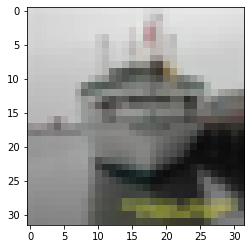

In [13]:
for images, labels in example:
    plt.imshow(images[0])

### Evaluation Pipeline

In [14]:
test_ds = ds_test \
    .cache() \
    .batch(BATCH_SIZE, drop_remainder=True) \
    .prefetch(tf.data.experimental.AUTOTUNE) 

In [15]:
def plot_history(history):
    plt.style.use('seaborn')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))    

    ax1.plot(acc, label="Training Accuracy")
    ax1.plot(val_acc, label="Validation Accuracy")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')    
    ax1.legend(loc='lower right')
    ax1.set_title("Training and Validation Accuracy")
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax2.plot(loss, label="Training Loss")
    ax2.plot(val_loss, label="Validation Loss")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')    
    ax2.legend(loc='upper right')
    ax2.set_title("Training and Validation Loss")
    
    plt.show()

# Resnet 50

In [43]:
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
base_model.trainable = False

# Data Augmentation

In [44]:
transforms = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [54]:
def get_pretrained_model(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
# #     x = Flatten()(x)
#     x = Dense(128, activation='relu')(x)    
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [55]:
resnet_model_v2 = get_pretrained_model(base_model)
resnet_model_v2.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_3  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_3 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [56]:
lr = 1e-3

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [57]:
# Let's see the eval accuracy before we train the model
resnet_model_v2.evaluate(test_ds)

78/78 [==============================] - 1s 12ms/step - loss: 6.1997 - accuracy: 0.0657


[6.199723243713379, 0.06570512801408768]

## Comet ML

I am use [comet](https://www.comet.ml) to track experiments. They have free plan for personal projects. You can also use W&B or just plain tensorboard as well 😀

In [58]:
experiment = Experiment(api_key=COMET_ML_API_KEY,
                        project_name="cf10-tensorflow", workspace="katnoria")
# add a tag
experiment.add_tag("R50+Drop+Dense")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-tensorflow/b80fd07c39a1499793cb77a108c4b6e3
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [50]           : (0.5623998641967773, 0.7302083373069763)
COMET INFO:     train_batch_accuracy [1950]   : (0.0546875, 0.828125)
COMET INFO:     train_batch_loss [1950]       : (0.5186846852302551, 6.366534233093262)
COMET INFO:     train_epoch_duration [50]     : (5.179524020000827, 7.028564379999807)
COMET INFO:     train_loss [50]               : (0.8127211332321167, 1.5457828044891357)
COMET INFO:     train_lr [50]                 : 0.0010000000474974513
COMET INFO:     train_val_accuracy [50]       : (0.6074719429016113, 0.6468349099159241)
COMET INFO:     train_val_loss [50]           : (1.1314399242401123, 1.4361

In [59]:
# We are going to train for 50 epochs
EPOCHS=50
with experiment.train():
    history = resnet_model_v2.fit(
        train_ds, epochs=EPOCHS, validation_data=test_ds, 
        verbose=2, callbacks=[reduce_lr]
    )

Epoch 1/50
390/390 - 5s - loss: 2.0248 - accuracy: 0.5117 - val_loss: 1.2012 - val_accuracy: 0.6260
Epoch 2/50
390/390 - 5s - loss: 1.3081 - accuracy: 0.6016 - val_loss: 1.1133 - val_accuracy: 0.6363
Epoch 3/50
390/390 - 5s - loss: 1.1957 - accuracy: 0.6155 - val_loss: 1.0942 - val_accuracy: 0.6389
Epoch 4/50
390/390 - 5s - loss: 1.1698 - accuracy: 0.6216 - val_loss: 1.0936 - val_accuracy: 0.6470
Epoch 5/50
390/390 - 5s - loss: 1.1572 - accuracy: 0.6263 - val_loss: 1.1395 - val_accuracy: 0.6306
Epoch 6/50
390/390 - 5s - loss: 1.1563 - accuracy: 0.6284 - val_loss: 1.1048 - val_accuracy: 0.6465
Epoch 7/50
390/390 - 5s - loss: 1.1680 - accuracy: 0.6232 - val_loss: 1.0877 - val_accuracy: 0.6450
Epoch 8/50
390/390 - 5s - loss: 1.1637 - accuracy: 0.6296 - val_loss: 1.1454 - val_accuracy: 0.6290
Epoch 9/50
390/390 - 5s - loss: 1.1603 - accuracy: 0.6259 - val_loss: 1.1184 - val_accuracy: 0.6374
Epoch 10/50
390/390 - 5s - loss: 1.1630 - accuracy: 0.6283 - val_loss: 1.1517 - val_accuracy: 0.6232

In [60]:
params = {
    "batch_size": BATCH_SIZE,
    "learning_rate": lr,
    "epochs": EPOCHS
}

In [61]:
experiment.log_parameters(params)

In [62]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-tensorflow/12ed043db6384b46a092d25eb5702d48
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [50]           : (0.5116786956787109, 0.6328125)
COMET INFO:     train_batch_accuracy [1950]   : (0.0625, 0.734375)
COMET INFO:     train_batch_loss [1950]       : (0.823480486869812, 7.332725524902344)
COMET INFO:     train_epoch_duration [50]     : (5.187726827000006, 6.995035760999599)
COMET INFO:     train_loss [50]               : (1.1538918018341064, 2.0247995853424072)
COMET INFO:     train_lr [50]                 : 0.0010000000474974513
COMET INFO:     train_val_accuracy [50]       : (0.6231971383094788, 0.6509414911270142)
COMET INFO:     train_val_loss [50]           : (1.0876882076263428, 1.2011876106262207)

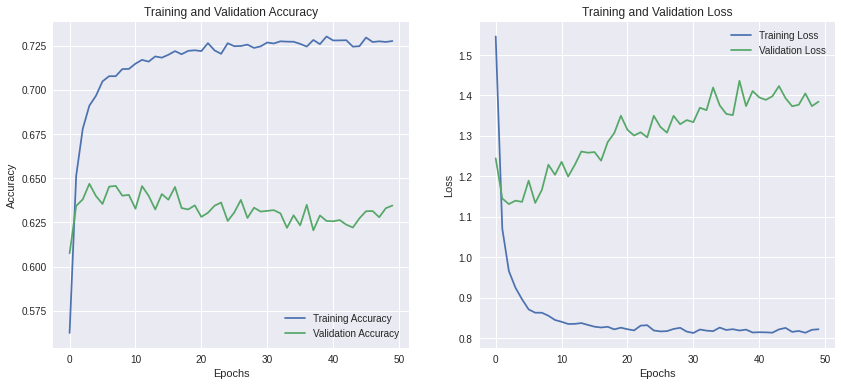

In [53]:
plot_history(history)

# Increase the network depth

If we notice the training accuracy, we see that we not not overfitting which probably means our network capacity is not enough. Let's now try to increase linear layers.

In [63]:
def get_pretrained_model_v4(base_model, transforms=None):
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if transforms is not None:
        x = transforms(inputs)
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x, training=False)
#     x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)        
    x = Dropout(0.7)(x)
    outputs = Dense(NUM_CLASSES)(x)
    _model = tf.keras.Model(inputs, outputs)    
    return _model

In [64]:
resnet_model_v4 = get_pretrained_model_v4(base_model, transforms)
resnet_model_v4.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_strided_slice_4  [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf_op_layer_BiasAdd_4 (Tenso [(None, 32, 32, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [65]:
experiment = Experiment(api_key="r3QI6mx4KaB3v0VMFwt6bcf33",
                        project_name="cf10-tensorflow", workspace="katnoria")
# add a tag
experiment.add_tag("R50+Dense+Drop+Dense")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/katnoria/cf10-tensorflow/6112baebec81432595efc6cd22b3ed73



In [66]:
lr = 1e-3

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

resnet_model_v4.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [67]:
# We are going to train for 50 epochs
EPOCHS=50
with experiment.train():
    history = resnet_model_v4.fit(
        train_ds, epochs=EPOCHS, validation_data=test_ds, 
        verbose=2, callbacks=[reduce_lr]
    )

Epoch 1/50
390/390 - 6s - loss: 1.6943 - accuracy: 0.4474 - val_loss: 1.1374 - val_accuracy: 0.6042
Epoch 2/50
390/390 - 5s - loss: 1.3316 - accuracy: 0.5340 - val_loss: 1.0730 - val_accuracy: 0.6271
Epoch 3/50
390/390 - 5s - loss: 1.2400 - accuracy: 0.5682 - val_loss: 1.0342 - val_accuracy: 0.6393
Epoch 4/50
390/390 - 5s - loss: 1.1886 - accuracy: 0.5845 - val_loss: 1.0098 - val_accuracy: 0.6467
Epoch 5/50
390/390 - 5s - loss: 1.1468 - accuracy: 0.6002 - val_loss: 0.9909 - val_accuracy: 0.6510
Epoch 6/50
390/390 - 5s - loss: 1.1127 - accuracy: 0.6111 - val_loss: 0.9823 - val_accuracy: 0.6583
Epoch 7/50
390/390 - 5s - loss: 1.0883 - accuracy: 0.6194 - val_loss: 0.9742 - val_accuracy: 0.6593
Epoch 8/50
390/390 - 5s - loss: 1.0610 - accuracy: 0.6287 - val_loss: 0.9608 - val_accuracy: 0.6659
Epoch 9/50
390/390 - 5s - loss: 1.0485 - accuracy: 0.6350 - val_loss: 0.9579 - val_accuracy: 0.6706
Epoch 10/50
390/390 - 5s - loss: 1.0310 - accuracy: 0.6408 - val_loss: 0.9645 - val_accuracy: 0.6669

In [68]:
params = {
    "batch_size": BATCH_SIZE,
    "learning_rate": lr,
    "epochs": EPOCHS
}
experiment.log_parameters(params)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/katnoria/cf10-tensorflow/6112baebec81432595efc6cd22b3ed73
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_accuracy [50]           : (0.4473758041858673, 0.7395432591438293)
COMET INFO:     train_batch_accuracy [1950]   : (0.0859375, 0.875)
COMET INFO:     train_batch_loss [1950]       : (0.42784979939460754, 9.46520709991455)
COMET INFO:     train_epoch_duration [50]     : (5.287976133000484, 7.827700731999357)
COMET INFO:     train_loss [50]               : (0.6868393421173096, 1.6942685842514038)
COMET INFO:     train_lr [50]                 : 0.0010000000474974513
COMET INFO:     train_val_accuracy [50]       : (0.6041666865348816, 0.6833934187889099)
COMET INFO:     train_val_loss [50]           : (0.943213939666748, 1.13740670

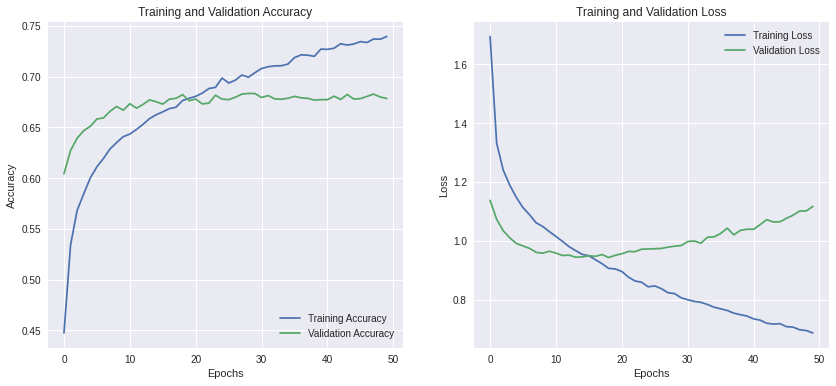

In [69]:
plot_history(history)

# Next

Well, at this point you could either manually try to tweak the network architecture or make use of hyperparameters tuning library such as Ray or Keras Tuner